# EzTaoX Example

In this notebook we look at how we can import and use models from [EzTaoX](https://github.com/LSST-AGN-Variability/EzTaoX), a package for simulating and analyzing AGNs.

Note that the eztaox package is not installed as part of the default LightCurveLynx installation. Users will need to manually install them via pip (e.g. `pip install eztaox`) in order to run this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import eztaox.kernels.quasisep as ekq

from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.math_nodes.basic_math_node import BasicMathNode
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.obstable.opsim import OpSim
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.eztaox_models import EzTaoXWrapperModel
from lightcurvelynx.utils.plotting import plot_lightcurves

## Create the Survey Data

There are two types of data files we need to run a LightCurveLynx simulation an `ObsTable` and passband information. In most cases we will want to load the simulated or actual observation tables from various surveys.

In this example we will use the default Rubin passbands. But we will create a fake observation cadence that is better for visualizing microlensing events. Specifically, we will take make two fake `OpSim` that observes the exact same location on the sky (45.0, -20.0) three times a night, once in each of the 'r", "g", and 'i' bands. This is particularly realistic for a survey, but provides densely sampled output curves for the purpose of this notebook. For examples of more realistic RA/dec distributions and opsims, see the other notebooks.

Note that we specify a lot of noise parameters with the fake `OpSim`, but in normal cases users will be loading a predefined opsim with all of that information pre-populated.

In [2]:
filters = ["g", "r", "i"]
passband_group = PassbandGroup.from_preset(preset="LSST", filters=filters)

num_days = 2000
mjd_start = 60676.0
mjd_end = mjd_start + num_days

num_samples = 50
survey_data = {
    "observationStartMJD": np.linspace(mjd_start, mjd_end, num_samples),
    "fieldRA": np.full(num_samples, 45.0),
    "fieldDec": np.full(num_samples, -20.0),
    "zp_nJy": np.random.normal(loc=1.0, scale=0.1, size=num_samples),
    "filter": [filters[i % 3] for i in range(num_samples)],
    "seeing": np.random.normal(loc=1.1, scale=0.1, size=num_samples),
    "skybrightness": np.random.normal(loc=20.0, scale=0.1, size=num_samples),
    "exptime": np.full(num_samples, 30.0),
    "nexposure": np.full(num_samples, 2),
}
obs_table = OpSim(survey_data)

## Create the model

Next we want to create a model of the physical phenomena that we would like to simulation (in this case an AGN). EzTaoX uses a *kernel* to model an AGN event and provides a variety of built-in kernel types. We start with a simple exponential kernel (damped random walk model), which has two parameters `scale` and `sigma`. When creating a new kernel we need to provide dummy initial values (these won't actually be used). 

In [3]:
kernel = ekq.Exp(scale=1, sigma=1)

Next we need to define the parameters for the kernel and the Gaussian process simulation.

ExTaoX performs a simulation that accounts for the different in bands, so will we need to tell the code which bands we are using (and their order). We use the same three bands as defined above (`filters` list).

### Kernel Parameters

The kernel parameters are the same as used in the object construction and are passed as a vector of log values with the order matching that of the constructor. Here we use a combination of LightCurveLynx's built-in math nodes and numpy sampling nodes to create samplers. Each of these samplers will *first* sample a number from a uniform distribution and then apply the logarithm. So the values accessed during the simulation (and fed into `MultiVarSim`) will be log values.

In [4]:
log_kernel_param = [
    BasicMathNode("log(scale)", scale=NumpyRandomFunc("uniform", low=1.0, high=10000.0)),
    BasicMathNode("log(sigma)", sigma=NumpyRandomFunc("uniform", low=0.01, high=2.0)),
]

This array now contains two `LightCurveLynx` samplers. The first will sample a scale uniformly from [1.0, 10000.0] and produce the log of that value. The second will sample a sigma uniformly from [0.01, 2.0] and produce the log of that value.

### GP Parameters

In addition the Gaussian process can take arrays of setters for `log_amp_scale` (length N), `mean` (length N-1), and `lag` (length N) where N is the number of filters. Only `log_amp_scale` is required. The other two are optional.

Here we provide precomputed fixed values of the `log_amp_scale` corresponding to amp_scales of 1.0, 0.8, and 0.5. Alternative we could specify the `log_amp_scale` as a list of NumpyRandomFunc. We could set up `mean` and `lag` arrays with similar approaches.

In [5]:
log_amp_scale = [0.0, -0.22, -0.69]

When using `zero_mean` the EzTaoX's Gaussian Process will simulate the change in magnitude. To be meaningful we need an initial (baseline) magnitude for the AGN. We specify this in a dictionary mapping filter name to the baseline magnitude. 

Again these can be any setter accepted by LightCurveLynx. Maybe we want to use constants for each AGN. Or baselines sampled from a distribution. We can even mix and match the setter types per-band.

In [6]:
baseline_mags = {
    "g": NumpyRandomFunc("normal", loc=24.0, scale=1.0),  # Gaussian around 24 mag
    "r": NumpyRandomFunc("normal", loc=24.0, scale=1.0),  # Gaussian around 24 mag
    "i": 23.0,  # Fixed baseline mag for i-band
}

### Other Object Parameters

In addition to the EzTaoX parameters, we need the standard parameters for a physical model such as RA, dec, and redshift.
* RA drawn uniformly from [44.0, 46.0]
* DEC drawn uniformly from [-19.0, -21.0]
* redshift drawn uniformly from [0.01, 0.5]

Since the field of view of a Rubin observation has a radius of 1.75 degrees, we can sample RA and DEC for our observations from a small region around the center of the image and know they will show up in all the images. 

In [7]:
ra_sampler = NumpyRandomFunc("uniform", low=44.0, high=46.0)
dec_sampler = NumpyRandomFunc("uniform", low=-21.0, high=-19.0)
redshift_sampler = NumpyRandomFunc("uniform", low=0.01, high=0.5)

### Model Creation

Now we are ready to create the model.

In [8]:
source = EzTaoXWrapperModel(
    kernel,  # The kernel to use
    baseline_mags=baseline_mags,  # A dict of baseline magnitude setters per band
    band_list=filters,  # A list of band names in order
    log_kernel_param=log_kernel_param,  # A list of setters for the kernel parameters
    log_amp_scale=log_amp_scale,  # A length N list of setters for the amplitude scales per band
    zero_mean=True,
    has_lag=False,
    ra=ra_sampler,
    dec=dec_sampler,
    redshift=redshift_sampler,
    node_label="source",  # A node name for convenience
)

Almost all of the parameters are randomly sampled. Let's look at a sampling.

In [9]:
sampled_state = source.sample_parameters(num_samples=1)

for key, val in sampled_state["source"].items():
    print(f"{key}: {val}")

ra: 45.666138388650566
dec: -19.744439834730162
redshift: 0.2902217077893863
t0: None
distance: None
eztaox_log_kernel_param_0: 7.986727006030101
eztaox_log_kernel_param_1: -0.2923138316316736
eztaox_log_amp_scale_0: 0.0
eztaox_log_amp_scale_1: -0.22
eztaox_log_amp_scale_2: -0.69
eztaox_baseline_mag_g: 24.10532094010821
eztaox_baseline_mag_r: 23.037967779828477
eztaox_baseline_mag_i: 23.0
eztaox_seed_param: 3853579597


If we sample again, we get different values (except for the baseline in i band, which is fixed at 23.0)

In [10]:
sampled_state = source.sample_parameters(num_samples=1)

for key, val in sampled_state["source"].items():
    print(f"{key}: {val}")

ra: 45.2934460608552
dec: -19.020745173951273
redshift: 0.22808479906545287
t0: None
distance: None
eztaox_log_kernel_param_0: 8.837071916677854
eztaox_log_kernel_param_1: 0.36958634664899137
eztaox_log_amp_scale_0: 0.0
eztaox_log_amp_scale_1: -0.22
eztaox_log_amp_scale_2: -0.69
eztaox_baseline_mag_g: 24.395766765240456
eztaox_baseline_mag_r: 25.11205730241306
eztaox_baseline_mag_i: 23.0
eztaox_seed_param: 472894499


## Generate the simulations

We can now generate random simulations with all the information defined above. The `simulate_lightcurves` function takes four parameters: the source from which we want to sample (here the collection of lightcurves), the number of results to simulate (100), the opsim, and the passband information. We also run simulations in parallel, using four processes and 25 light curves per simulation batch.

In [11]:
lightcurves = simulate_lightcurves(
    source,
    5,
    obs_table,
    passband_group,
)

Simulating: 100%|██████████| 5/5 [00:01<00:00,  2.78obj/s]


The results are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. Each row corresponds to a single simulated object, with a unique id, ra, dec, etc. The column `params` include all internal state, including hyperparameter settings, that was used to generate this object. The nested `lightcurve` column contains the times, filters, and fluxes for each observation of that object.  We can treat it as a (nested) table.

Let's look at the lightcurve for the first object sampled:

In [12]:
print(lightcurves.loc[0]["lightcurve"])

             mjd filter         flux     fluxerr  flux_perfect  survey_idx  \
0   60676.000000      g  2039.719702  329.828871   1246.526025           0   
1   60716.816327      r  2038.180092  370.426469   1889.781675           0   
..           ...    ...          ...         ...           ...         ...   
48  62635.183673      g  5089.358207  367.674903   4490.267476           0   
49  62676.000000      r  5765.493277  343.336867   6214.952808           0   

    obs_idx  is_saturated  
0         0         False  
1         1         False  
..      ...           ...  
48       48         False  
49       49         False  

[50 rows x 8 columns]


Let's see where we generated the observations by using the results RA and dec columns. As expected the are within a box in the center of the field of view.

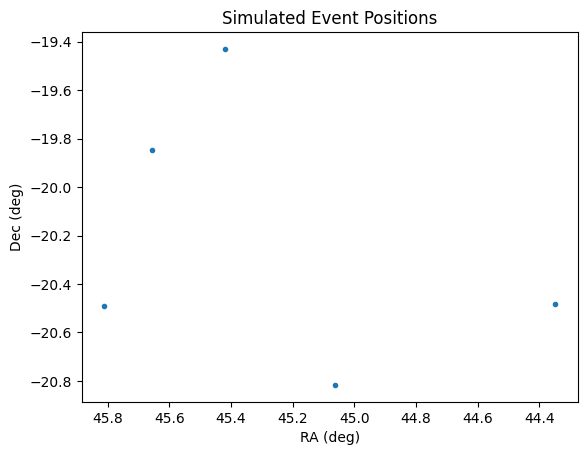

In [13]:
plt.plot(lightcurves["ra"], lightcurves["dec"], ".")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.gca().invert_xaxis()
plt.title("Simulated Event Positions")
plt.show()

As noted above, these points are all clustered within the single viewing window of the survey so that we can get dense curves.

Now let's plot the first few lightcurves to see what they look like when observed via Rubin's cadence.

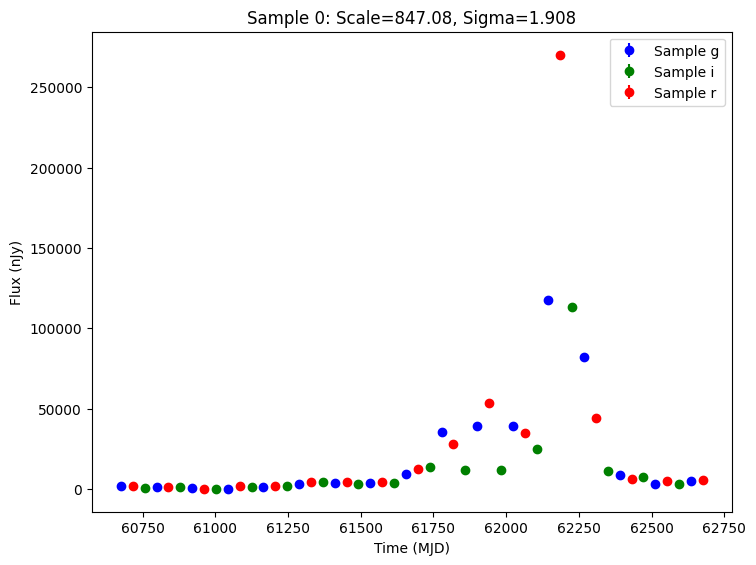

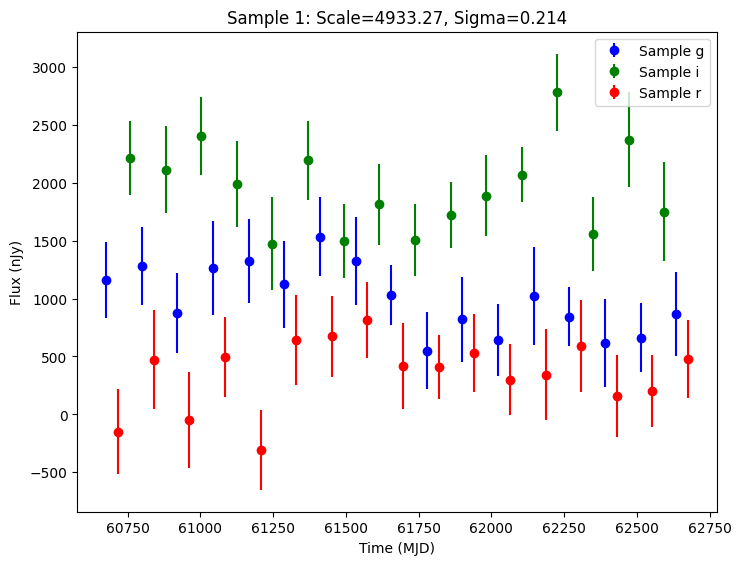

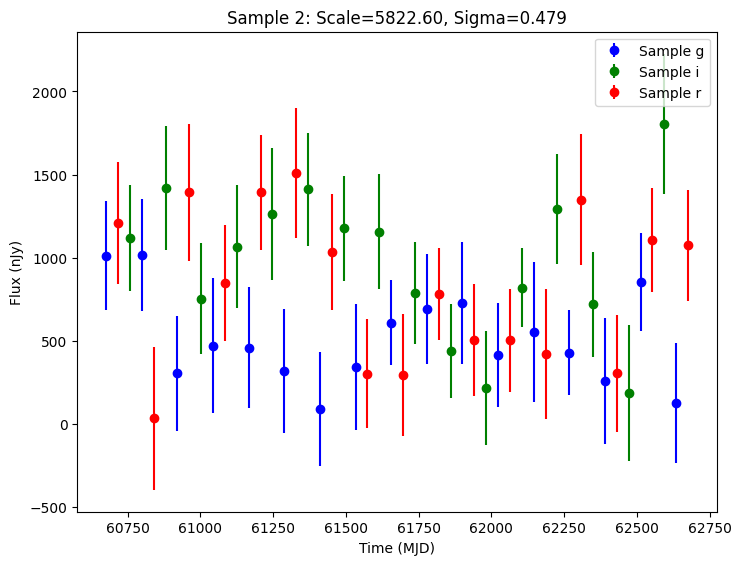

In [14]:
for idx in range(3):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    if lc["nobs"] == 0:
        continue

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    scale = np.exp(lc["params"]["source.eztaox_log_kernel_param_0"])
    sigma = np.exp(lc["params"]["source.eztaox_log_kernel_param_1"])

    # Plot the lightcurves.
    ax = plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"Sample {idx}: Scale={scale:.2f}, Sigma={sigma:.3f}",
    )
    ax.legend()
    plt.show()

## Setting the Seed

As described in the LightCurveLynx documentation, it is possible to force deterministic behavior for debugging by passing a random number generator to the sampling or simulation functions. However, this only addresses the randomness during parameter sampling. 

The EZTaoX code itself uses randomness when simulating the AGN. We can force deterministic behavior using the class's `seed_param` argument when constructing the object (e.g. `seed_param=42`).

**NOTE**: This should only be done for testing. For actual scientific analysis, you will want actual random behavior.